In [129]:
import pickle 
import matplotlib.pyplot as plt
import numpy as np
import skopt



def objective_function(x: list):
    dropout_probs = x[0]
    final_layer = x[1]
    in_channels = 1
    CNN_model = VGG16(num_classes=2, in_channels=in_channels, features_fore_linear=36864, dataset=test_set, dropout_probs=dropout_probs, final_layer=final_layer) 
    train_epochs = 1
    train_accs, val_accs = CNN_model.train_model(train_dataloader, epochs=train_epochs)
    acc = CNN_model.eval_model(test_dataloader)
    
    return - acc

with open("opt502.pkl", "rb") as f: 
    opt = pickle.load(f)

with open("rnd_best_params502.pkl", "rb") as f: 
    rnd_best_params = pickle.load(f)

with open("rnd_scores502.pkl", "rb") as f: 
    scores = pickle.load(f)
    
runs = 50
dropout_probs = (0, 0.95)
final_layer = (0, 1000)

In [ ]:
xs = np.arange(1, runs + 1, 1)
random_points = -np.array(scores)
random_best = np.maximum.accumulate(-np.array(scores)).ravel()
opt_points = np.array(-opt.func_vals)
opt_best = np.maximum.accumulate(-opt.func_vals).ravel()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50])

In [147]:
print("Best parameters:", opt.x)


Best parameters: [0.0, np.int64(348)]


In [149]:
print("Best objective function value:", -opt.fun)

Best objective function value: 0.9637681159420289


In [175]:
print("All tested parameter values:", opt.x_iters[46])
print("Corresponding function values:", opt.func_vals[46])


All tested parameter values: [0.0, np.int64(348)]
Corresponding function values: -0.9637681159420289


In [ ]:
from skopt import expected_minimum

best_x, best_y = expected_minimum(op, seed=1)
print("Expected minimum:", best_x, "Expected function value:", best_y)


Expected minimum: [np.float64(0.19521924766822968), np.float64(949.0)] Expected function value: -0.9574880140929118


In [142]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Create a figure with custom GridSpec to allow different subplot sizes
fig = plt.figure(figsize=(10, 8), dpi=500)  # Overall figure size
gs = GridSpec(2, 1, height_ratios=[6, 2])  # Ratio of 7:4 for the two subplots

# First subplot (top)
ax1 = fig.add_subplot(gs[0])
ax1.set_ylim(0.95 * min(random_points), max(opt_best) * 1.05)
ax1.plot(xs, random_best, '-', color='red', label='Random Search best')
ax1.plot(xs, opt_best, '-', color='blue', label='Bayesian Optimization best')
ax1.plot(xs, opt_points, 'o', color='blue', label='Bayesian Optimization')
ax1.plot(xs, random_points, 'o', color='red', label='Random Search')
ax1.legend()
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Accuracy')
ax1.set_title('Comparison between Random Search and Bayesian Optimization (full range)')

# Second subplot (bottom)
ax2 = fig.add_subplot(gs[1])
ax2.set_ylim(0.95, 0.97)
ax2.plot(xs, random_best, '-', color='red', label='Random Search best')
ax2.plot(xs, opt_best, '-', color='blue', label='Bayesian Optimization best')
ax2.plot(xs, opt_points, 'o', color='blue', label='Bayesian Optimization')
ax2.plot(xs, random_points, 'o', color='red', label='Random Search')
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Accuracy')
ax2.set_title('Comparison between Random Search and Bayesian Optimization (zoomed in)')

plt.tight_layout()  # Adjust spacing between subplots

# Save as PDF instead of displaying
plt.savefig('optimization_comparison.pdf', bbox_inches='tight')
plt.close()  # Close the figure to free memory

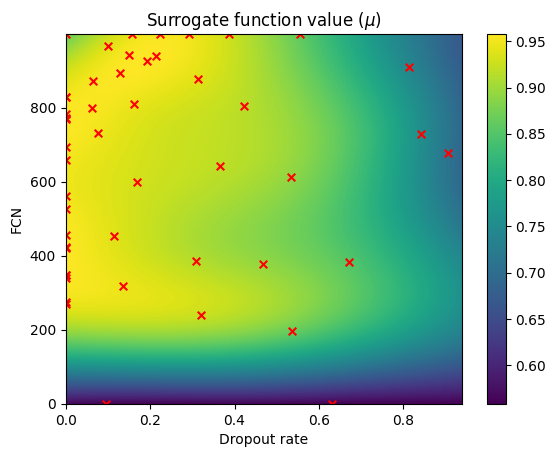

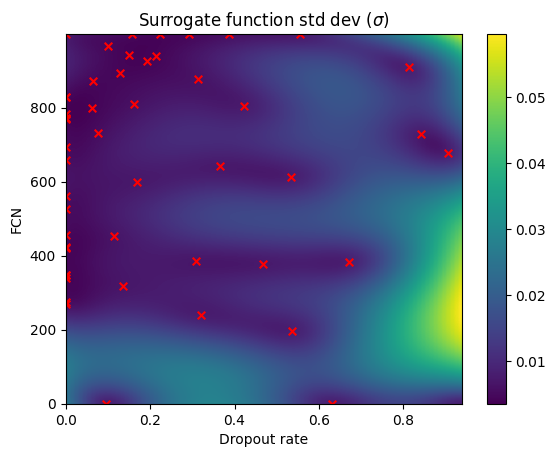

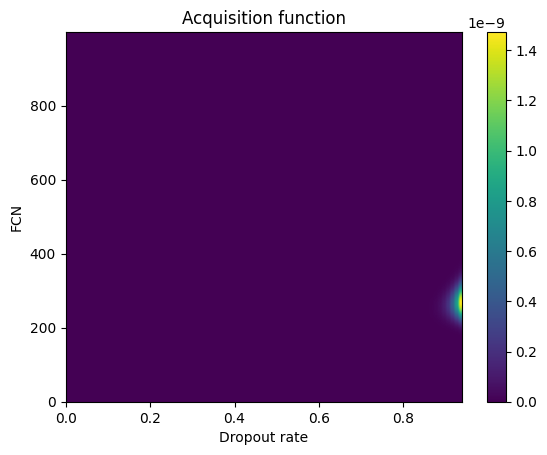

In [178]:

model = opt.models[-1]
pgrid = np.array(np.meshgrid(np.arange(dropout_probs[0],0.95, 0.01), 
                             np.arange(*final_layer), indexing='ij'))
pgrid_norm = np.array([opt.space[i][1].transform(x) for i, x in enumerate(pgrid.reshape(2, -1))])

extra_dims = np.zeros((4, pgrid_norm.shape[1]))
extra_dims[0, :] = 1
pgrid_norm = np.concatenate((pgrid_norm, extra_dims), axis=0)

# Keep only the first two dimensions for plotting
pgrid_norm = pgrid_norm[:2, :]
ye, ye_std = model.predict(X=pgrid_norm.T, return_std=True)

# Reshape outputs to fit the grid structure
ye_img = -np.array(ye).reshape(pgrid[0].shape[:2])
ye_std_img = np.array(ye_std).reshape(pgrid[0].shape[:2])

# For plotting points searched
xx = [i[0] for i in opt.x_iters]
yy = [i[1] for i in opt.x_iters]

# Set up figure
plt.figure()
plt.scatter(xx, yy, c='red', marker='x', label='Optimized points', s=30)
plt.imshow(ye_img.T, origin='lower', extent=[pgrid[0].min(), pgrid[0].max(), pgrid[1].min(), pgrid[1].max()], aspect='auto')
plt.colorbar()  # Set x-axis to log scale
plt.xlabel('Dropout rate')
plt.ylabel('FCN')
plt.title('Surrogate function value ($\\mu$)')
plt.savefig('Surrogate_function_mean.pdf', bbox_inches='tight')


plt.figure()
plt.scatter(xx, yy, c='red', marker='x', label='Optimized points', s=30)
plt.imshow(ye_std_img.T, origin='lower', extent=[pgrid[0].min(), pgrid[0].max(), pgrid[1].min(), pgrid[1].max()], aspect='auto')
plt.colorbar() # Set x-axis to log scale
plt.xlabel('Dropout rate')
plt.ylabel('FCN')
plt.title('Surrogate function std dev ($\\sigma$)')

plt.savefig('Surrogate_function_std_dev.pdf', bbox_inches='tight')

#evaluate the acqusition function using skopt.acquisition.gaussian_ei and plot it
acq_val = skopt.acquisition.gaussian_ei(X=pgrid_norm.T, model=model,xi=0.1,y_opt=opt.fun,return_grad=False)
acq_val_img = np.array(acq_val).reshape(pgrid[0].shape[:2])

plt.figure()
plt.imshow(acq_val_img.T, origin='lower', extent=[pgrid[0].min(), pgrid[0].max(), pgrid[1].min(), pgrid[1].max()], aspect='auto')
plt.colorbar()
plt.xlabel('Dropout rate')
plt.ylabel('FCN')
plt.title('Acquisition function')

plt.savefig('aquasition_function.pdf', bbox_inches='tight')
